In [1]:
import os
from image_preprocessing_agent import ImagePreprocessingAgent
from graph_rag import GraphRag
from data_input_agent import data_input_pipeline_agent, entity_prompt
from dotenv import load_dotenv

/opt/anaconda3/envs/RAG/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()
GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY")


In [3]:
gr = GraphRag()
gr.initiate_graph()

Loading embedding model: BAAI/bge-m3


Run the following cypher only one time on neo4j browser

In [4]:
# print(gr.neo4j_create_vector_index_cypher())

In [5]:
gr.load_temp_dataset("naver-clova-ix/cord-v2")
images = gr.get_sample_images()

In [8]:
from io import BytesIO
from google.adk.runners import InMemoryRunner
from google import genai
import json

async def ingest_dataset_samples(gr, num_samples=10):
    client = genai.Client(api_key=GOOGLE_API_KEY)

    images = gr.get_sample_images(num_samples)

    for i, img in enumerate(images):
        print(f"\n===== Processing sample {i} =====")

        result = client.models.generate_content(
            model="gemini-2.5-flash",
            contents=[entity_prompt, img]
        )

        raw_text = result.candidates[0].content.parts[0].text

        if raw_text.startswith("```"):
            raw_text = raw_text.strip("```json").strip("```")

        try:
            data = json.loads(raw_text)
        except Exception as e:
            print("JSON Parse Error:", raw_text)
            continue

        # Extract entity/relationship lists
        entities = data.get("entities", [])
        relationships = data.get("relationships", [])

        receipt_id = f"dataset_{i}"

        print(f"➡ Inserting {len(entities)} entities and {len(relationships)} relationships")

        # Insert Entities
        for ent in entities:
            gr.create_entity_node(
                entity_id=ent["id"],
                entity_type=ent["type"],
                properties={**ent.get("properties", {}), "receipt_id": receipt_id}
            )


        # Insert Relationships
        for rel in relationships:
            gr.create_relationship(rel)

    print("\nIngestion complete!")

In [9]:
await ingest_dataset_samples(gr, 1)


===== Processing sample 0 =====
➡ Inserting 23 entities and 22 relationships
Created relationship: receipt_1 -[HAS_ITEM]-> item_1
Created relationship: receipt_1 -[HAS_ITEM]-> item_2
Created relationship: receipt_1 -[HAS_ITEM]-> item_3
Created relationship: receipt_1 -[HAS_ITEM]-> item_4
Created relationship: receipt_1 -[HAS_ITEM]-> item_5
Created relationship: receipt_1 -[HAS_ITEM]-> item_6
Created relationship: receipt_1 -[HAS_ITEM]-> item_7
Created relationship: receipt_1 -[HAS_ITEM]-> item_8
Created relationship: receipt_1 -[HAS_ITEM]-> item_9
Created relationship: receipt_1 -[HAS_ITEM]-> item_10
Created relationship: receipt_1 -[HAS_ITEM]-> item_11
Created relationship: receipt_1 -[HAS_ITEM]-> item_12
Created relationship: receipt_1 -[HAS_ITEM]-> item_13
Created relationship: receipt_1 -[HAS_ITEM]-> item_14
Created relationship: receipt_1 -[HAS_ITEM]-> item_15
Created relationship: receipt_1 -[HAS_ITEM]-> item_16
Created relationship: receipt_1 -[HAS_ITEM]-> item_17
Created relat

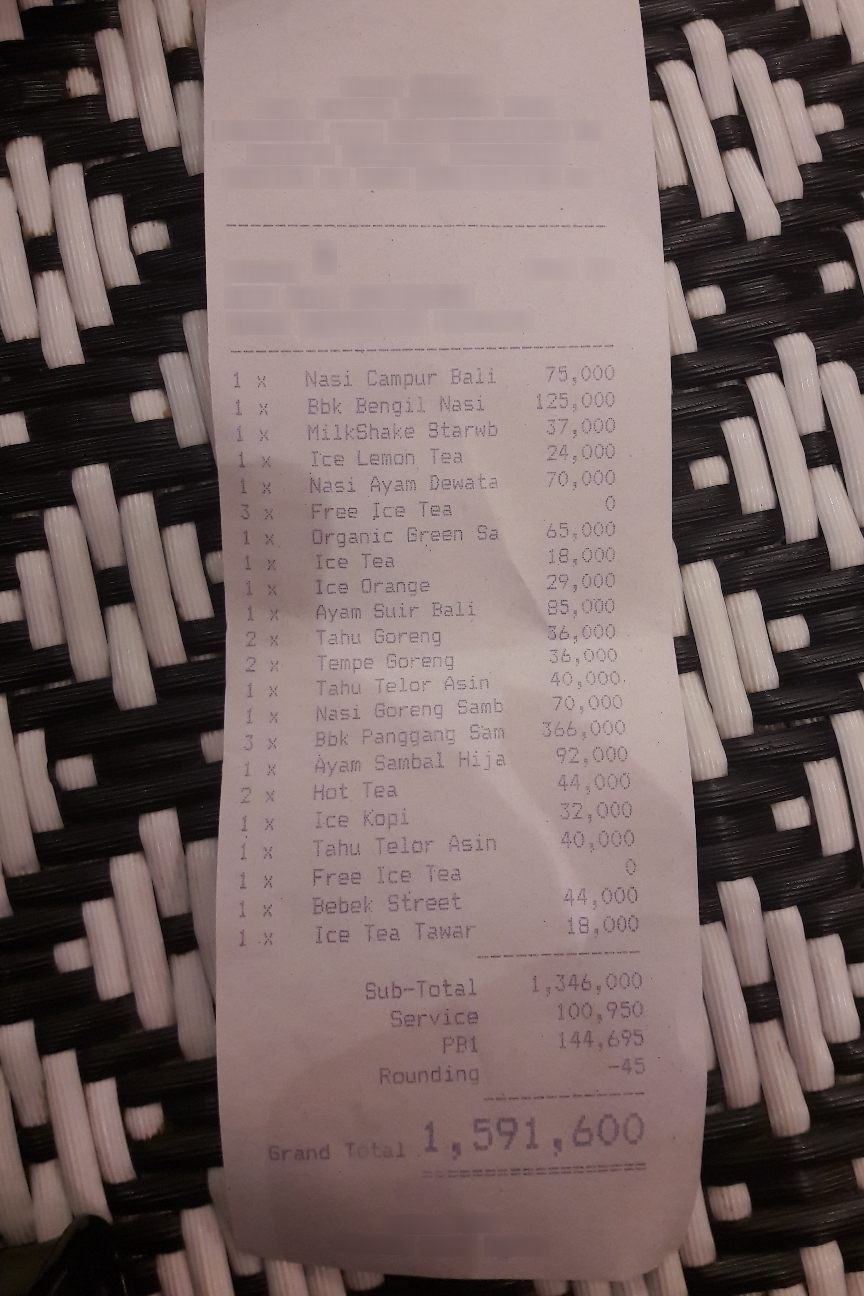

In [10]:
images = gr.get_sample_images()
images[0]

In [14]:
from google.adk.tools import AgentTool
from google.adk.tools import ToolContext
from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini

async def ingest_dataset_samples_tool(image_input: str):
    client = genai.Client(api_key=GOOGLE_API_KEY)

    result = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[entity_prompt, image_input]
    )

    raw_text = result.candidates[0].content.parts[0].text
    if raw_text.startswith("```"):
        raw_text = raw_text.strip("```json").strip("```")

    try:
        data = json.loads(raw_text)
    except Exception as e:
        return {"status": "error", "error_message": f"JSON Parse Error: {str(e)}"}

    entities = data.get("entities", [])
    relationships = data.get("relationships", [])

    receipt_id = f"dataset_ingest"

    for ent in entities:
        gr.create_entity_node(ent, receipt_id)

    for rel in relationships:
        gr.create_relationship(rel)

    return {
        "status": "success",
        "entities_created": len(entities),
        "relationships_created": len(relationships)
    }

def get_query_embedding(query: str) -> dict:
    """Return BGE-M3 embedding for a query."""
    emb = gr.embedding_manager.get_embedding(query)
    return {"embedding": emb, "status": "success"}

def retrieve_from_graph(query: str, top_k: int = 5) -> dict:
    """Hybrid retrieve top-K nodes from Neo4j for the query."""
    results = gr.hybrid_retrieve(query, top_k_vector=top_k, expand_neighbors=2)
    return {"results": results, "status": "success"}

retrieval_agent = LlmAgent(
    name="retrieval_agent",
    model=Gemini(model="gemini-2.5-flash"),
    instruction="""
You are a RAG assistant. For any user query:

1. Call `get_query_embedding(query)` to compute embedding.
2. Call `retrieve_from_graph(query)` to get relevant nodes.
3. Optionally, call `ingest_dataset_samples_tool(image_input)` if user provides a new receipt image.
4. Use retrieved context to answer the query concisely.
""",
    tools=[get_query_embedding, retrieve_from_graph, ingest_dataset_samples_tool],
    output_key="answer"
)

In [15]:
app_runner = InMemoryRunner(agent=retrieval_agent)


In [16]:
await app_runner.run_debug(
    "I want to check if I ordered any coffee"
)


 ### Created new session: debug_session_id

User > I want to check if I ordered any coffee


retrieval_agent > No, based on the retrieved information, you did not order any coffee. The items found were Hot Tea, Free Ice Tea, and MilkShake Starwb.


[Event(model_version='gemini-2.5-flash', content=Content(
   parts=[
     Part(
       function_call=FunctionCall(
         args={
           'query': 'I want to check if I ordered any coffee'
         },
         id='adk-ea6d28ff-97b7-428a-9be1-9af30851e5be',
         name='retrieve_from_graph'
       ),
       thought_signature=b'\n\xf1\x02\x01r\xc8\xda|\x0cN\xe7J\xbb\x97\xa2T\xc6\xe79\xc2R\xb3\xc44\x9dJu\nZ\xa9\xa0\xcb\xcc\x8a+\x88\x1f\x9dQ\x00\xecsS\x17)i\xa65\'#\xde\x1d~~5\xd7\x04{0L\x9e\xc0 \x8d\xf2v\xe67n\xe6\x1e\xbb\xab\x8a\xa6J\xb8\x1exp\xa74\x83mj\x95\xd7\x1a;u$"\xd2\x9e\xb6\xb2\'...'
     ),
   ],
   role='model'
 ), grounding_metadata=None, partial=None, turn_complete=None, finish_reason=<FinishReason.STOP: 'STOP'>, error_code=None, error_message=None, interrupted=None, custom_metadata=None, usage_metadata=GenerateContentResponseUsageMetadata(
   candidates_token_count=25,
   prompt_token_count=269,
   prompt_tokens_details=[
     ModalityTokenCount(
       modality=<MediaM